In [1]:
%pip install qiskit --quiet
%pip install qiskit-aer --quiet
%pip install matplotlib --quiet
%pip install pylatexenc --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# QuantumDB #
### A different look at relational databases

#### Derived from Gueddana et al. https://doi.org/10.1142/S0219749914500233, https://doi.org/10.1109/ICTON.2010.5549171

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram
import numpy as np

In [3]:
qa = QuantumRegister(3, 'a')
qb = QuantumRegister(3, 'b')
aux = QuantumRegister(1, 'aux')
z = QuantumRegister(1, 'z')
cr = ClassicalRegister(3, 'c')
qc = QuantumCircuit(qa, qb, aux, z, cr)

qaRegs = qa[:]
qbRegs = qb[:]

# Creating a Quantum Table

![image](./images/depTable.png "Department Table")

The DepNum and DepName are stored classically, we will focus on the quantum mappings between $K^1$ and $D^1_1$

/home/sum/Documents/QuantumDB/QuantumDB/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


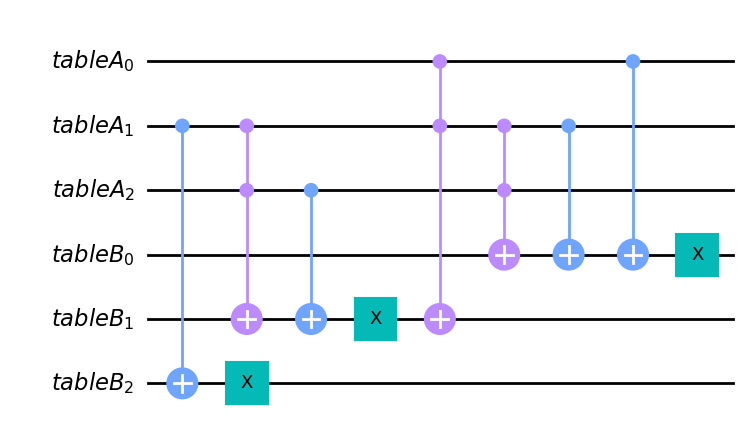

In [4]:
tableA = QuantumRegister(3, 'tableA')
tableB = QuantumRegister(3, 'tableB')
t1 = QuantumCircuit(tableA, tableB)

t1.cx(tableA[1], tableB[2])
t1.x(tableB[2])

t1.ccx(tableA[1], tableA[2], tableB[1])
t1.cx(tableA[2], tableB[1])
t1.x(tableB[1])
t1.ccx(tableA[0], tableA[1], tableB[1])

t1.ccx(tableA[1], tableA[2], tableB[0])
t1.cx(tableA[1], tableB[0])
t1.cx(tableA[0], tableB[0])
t1.x(tableB[0])


table1 = t1.to_gate(label='table1')
t1.draw(output='mpl')


## Performing a search (SELECT query)

### This is Grover's Search Algorithm!

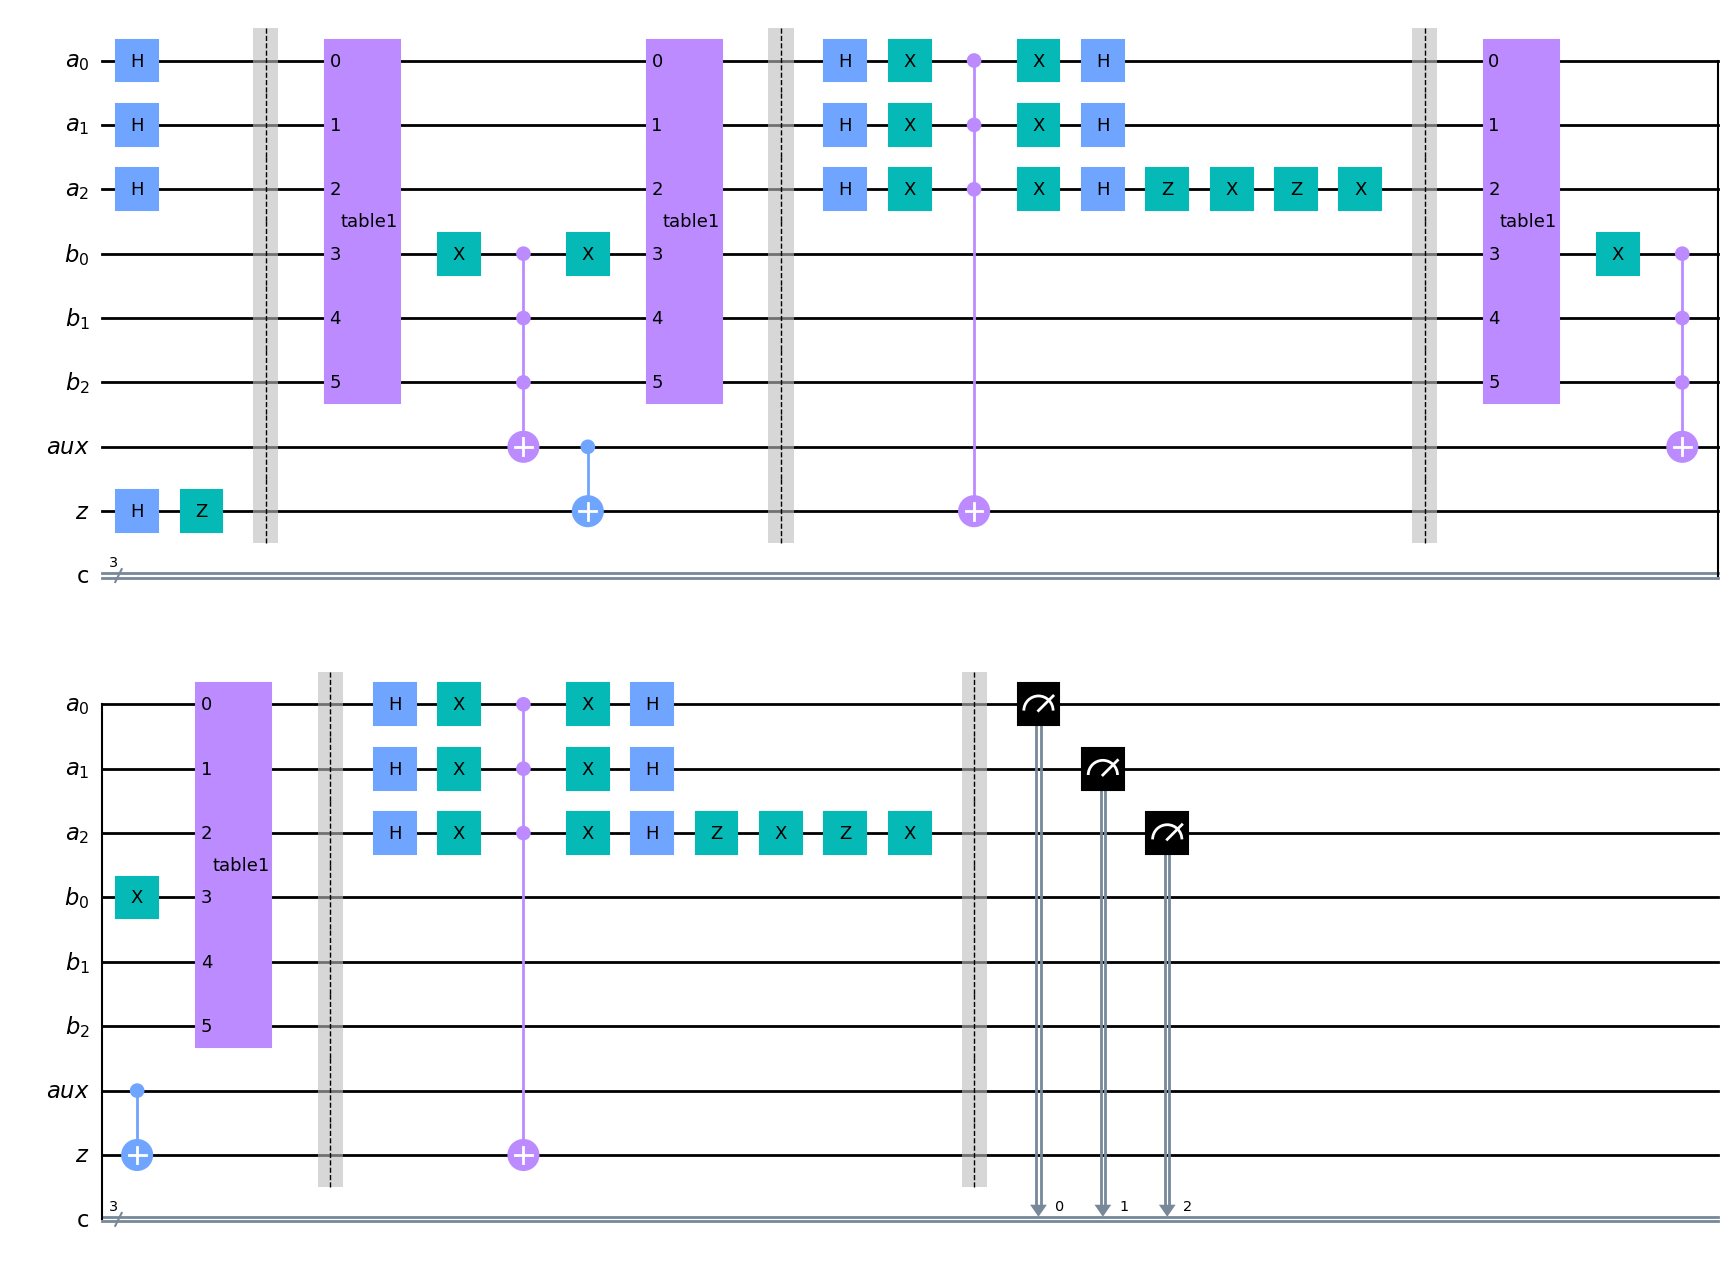

In [22]:
# Let's search for qb = 4, should get 101 (5) as output\
def search(num, doMeasurement=False):
    qa = QuantumRegister(3, 'a')
    qb = QuantumRegister(3, 'b')
    aux = QuantumRegister(1, 'aux')
    z = QuantumRegister(1, 'z')
    cr = ClassicalRegister(3, 'c')
    qc = QuantumCircuit(qa, qb, aux, z, cr)

    qaRegs = qa[:]
    qbRegs = qb[:]

    M = int(np.floor(np.pi/4 * np.sqrt(2**len(qaRegs))))
    binary = bin(num)[2:]
    binary = '0'*(len(qa)-len(binary)) + binary
    
    qc.h(z)
    qc.z(z)
    qc.h(qaRegs)
    qc.barrier()
    for i in range(M):
        qc.append(table1, qaRegs[:] + qbRegs[:])
        for j in range(len(binary)):
            if binary[j] == '0':
                qc.x(qbRegs[len(binary)-j-1])

        qc.mcx(qbRegs, aux)

        for j in range(len(binary)):
            if binary[j] == '0':
                qc.x(qbRegs[len(binary)-j-1])

            
        qc.append(table1, qaRegs[:] + qbRegs[:])
        qc.cx(aux, z)
        qc.barrier()

        qc.h(qaRegs)
        qc.x(qaRegs)
        qc.mcx(qaRegs, z)
        qc.x(qaRegs)
        qc.h(qaRegs)
        qc.z(qaRegs[len(qaRegs)-1])
        qc.x(qaRegs[len(qaRegs)-1])
        qc.z(qaRegs[len(qaRegs)-1])
        qc.x(qaRegs[len(qaRegs)-1])
        qc.barrier()

    qc.measure(qa, cr)

    if doMeasurement:
        backend = Aer.get_backend('qasm_simulator')
        job = execute(qc, backend, shots=1024)
        result = job.result()
        counts = result.get_counts(qc)
        return int(max(counts, key=counts.get), 2)

    return qc
    
searchCircuit = search(6)
searchCircuit.draw(output='mpl')

{'110': 2, '000': 4, '010': 4, '100': 6, '111': 3, '011': 5, '001': 21, '101': 5}


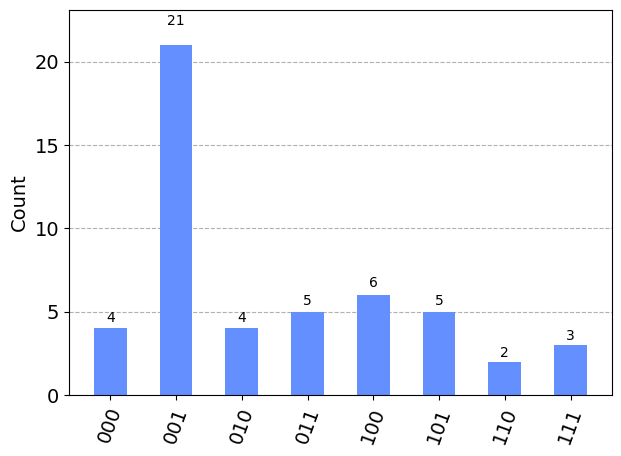

In [6]:
backend = Aer.get_backend('qasm_simulator')
job = execute(searchCircuit, backend, shots=50)
result = job.result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

## Performing an Insert (INSERT query)

6


/home/sum/Documents/QuantumDB/QuantumDB/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


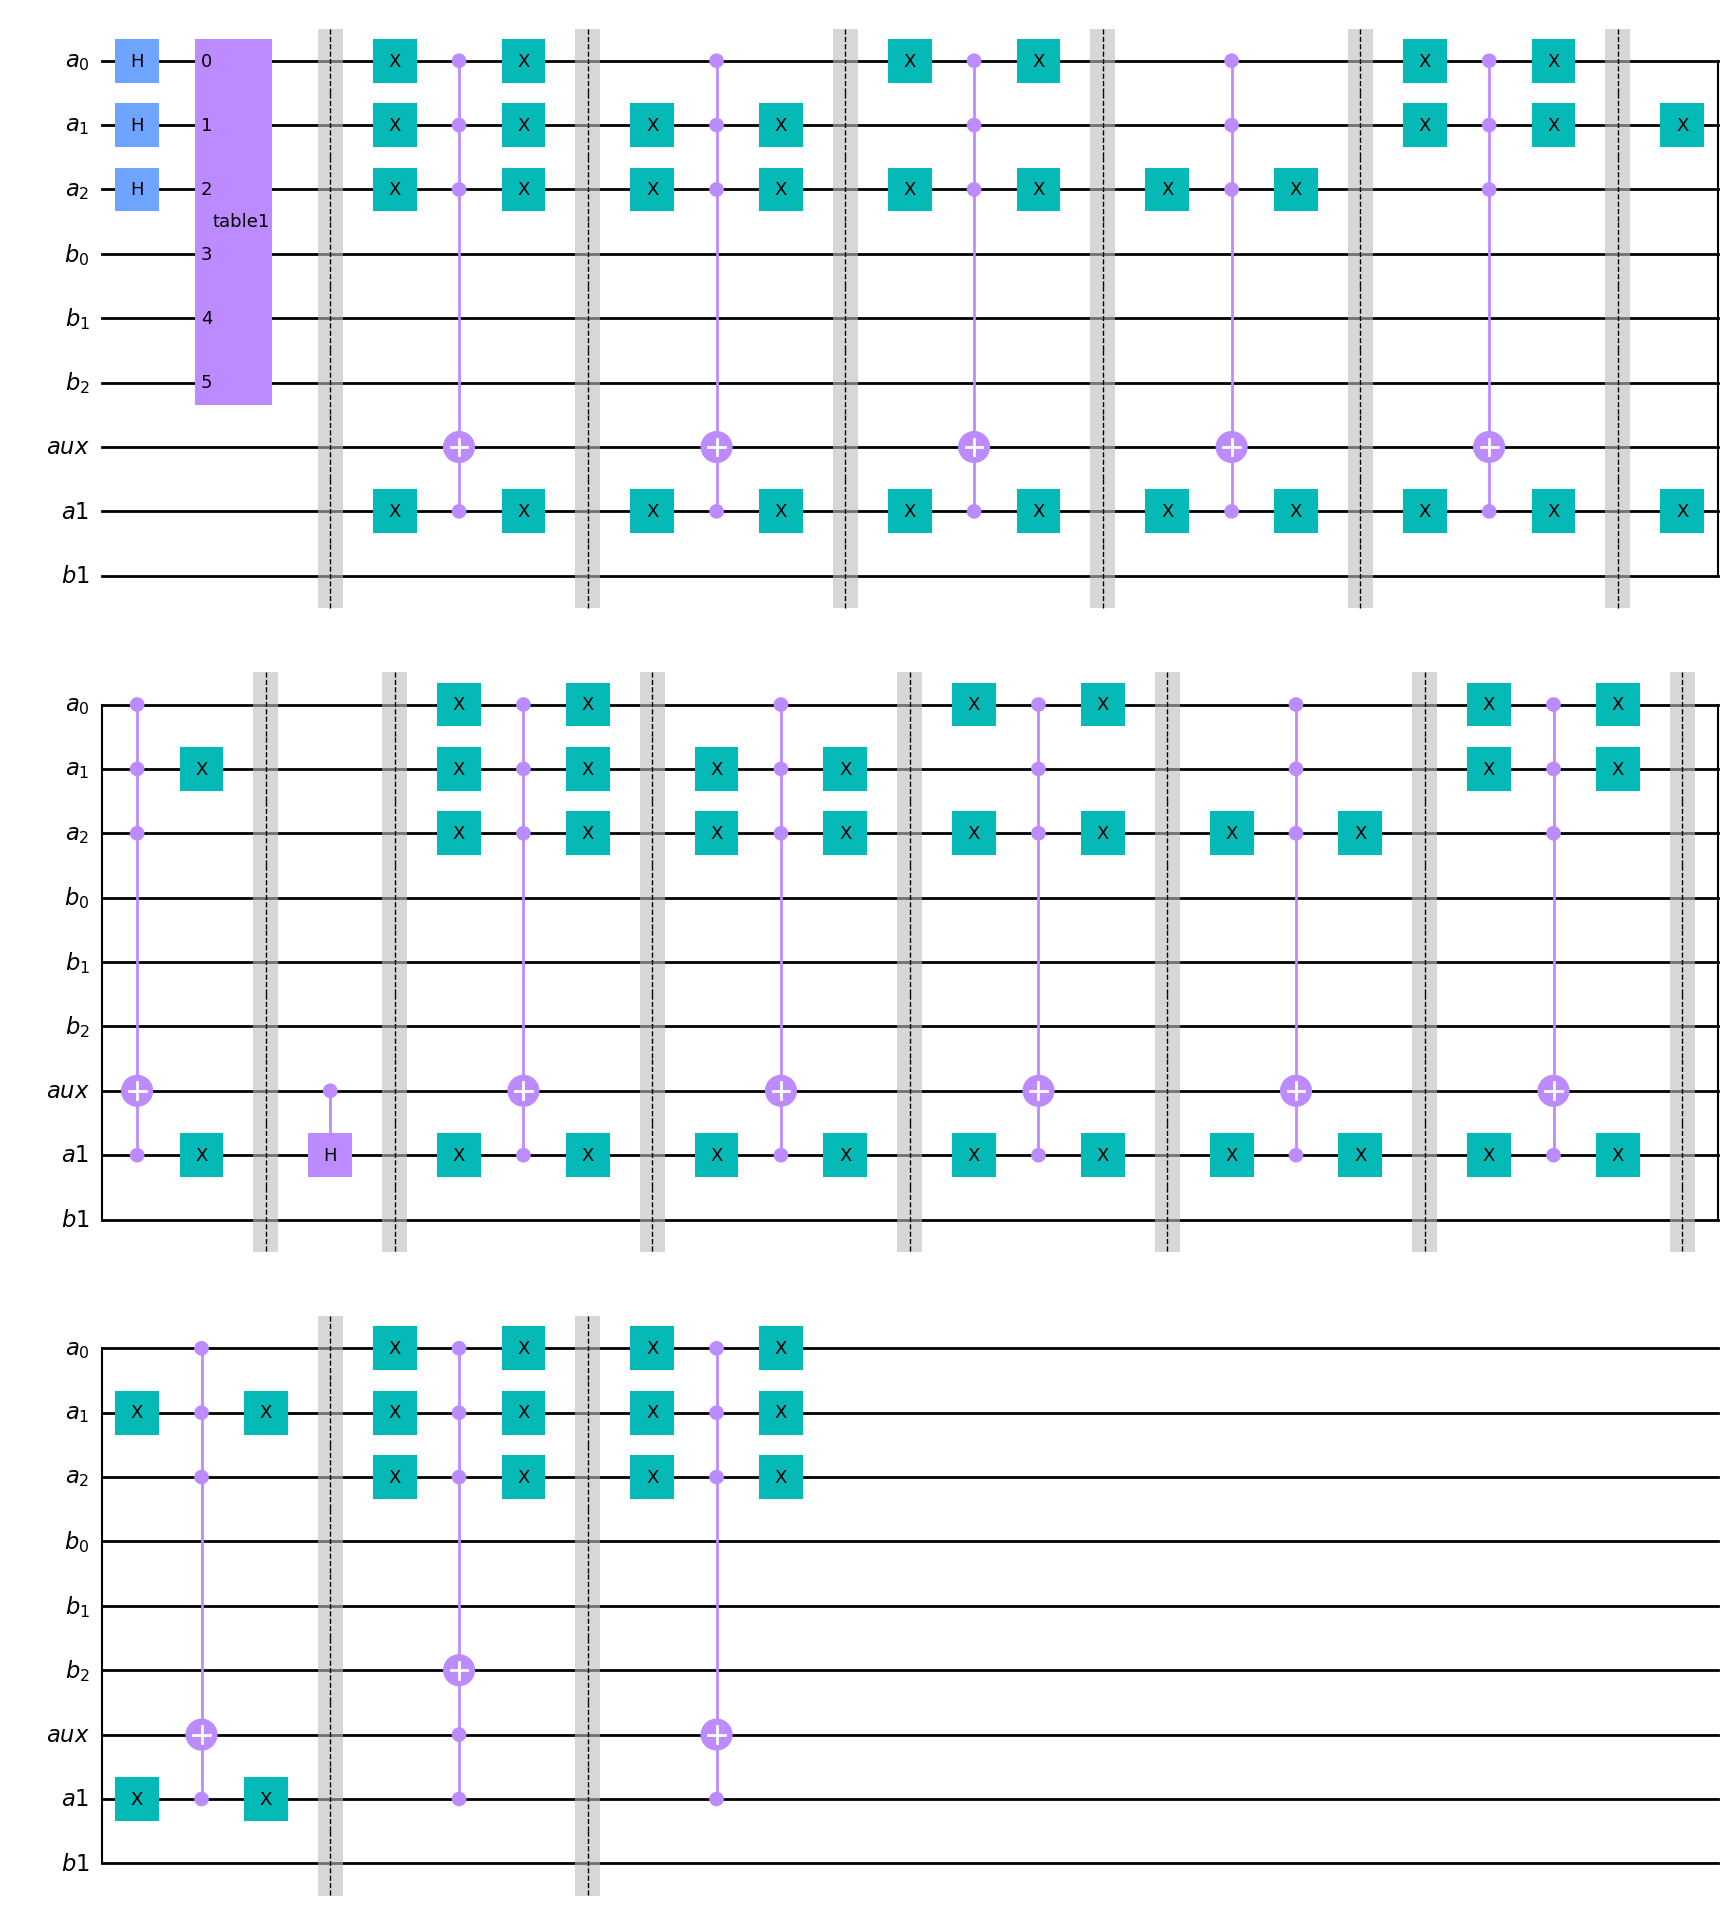

In [140]:
def insert():
    qa = QuantumRegister(3, 'a')
    qb = QuantumRegister(3, 'b')
    aux = QuantumRegister(1, 'aux')
    qc = QuantumCircuit(qa, qb, aux)

    qaRegs = qa[:]
    qbRegs = qb[:]

    usedStates = 0
    Nplus = int((np.pi/4 * np.floor(np.pi/4 * np.sqrt(2**len(qaRegs))) + 1)**2 - usedStates)
    S = min(Nplus, 2**len(qaRegs) - usedStates)

    qc.h(qaRegs)
    qc.append(table1, qaRegs[:] + qbRegs[:])

    # Inserting 8 into table
    qa1 = QuantumRegister(1, 'a1')
    qb1 = QuantumRegister(1, 'b1')
    qc.add_register(qa1)
    qc.add_register(qb1)
    qaRegs += qa1[:]
    qbRegs += qb1[:]

    qc.barrier()

    # Stage 1: Controlling on prev states (0-5)
    for i in range(S):
        binary = bin(i)[2:]
        binary = '0'*(len(qaRegs)-len(binary)) + binary
        for j in range(len(binary)):
            if binary[j] == '0':
                qc.x(qaRegs[len(binary)-j-1])
        qc.mcx(qaRegs, aux)
        for j in range(len(binary)):
            if binary[j] == '0':
                qc.x(qaRegs[len(binary)-j-1])
        qc.barrier()

    qc.ch(aux, qaRegs[3])
    qc.barrier()

    # Stage 2
    for i in range(S):
        binary = bin(i)[2:]
        binary = '0'*(len(qaRegs)-len(binary)) + binary
        for j in range(len(binary)):
            if binary[j] == '0':
                qc.x(qaRegs[len(binary)-j-1])
        qc.mcx(qaRegs, aux)
        for j in range(len(binary)):
            if binary[j] == '0':
                qc.x(qaRegs[len(binary)-j-1])
        qc.barrier()

    # Stage 3
    qc.x(qaRegs[0:3])
    qc.mcx(qaRegs[:] + aux[:], qbRegs[2])
    qc.x(qaRegs[0:3])
    qc.barrier()
    
    # Stage 4
    qc.x(qaRegs[0:3])
    qc.mcx(qaRegs, aux)
    qc.x(qaRegs[0:3])

    qc.draw(output='mpl')
    # qc.measure(qaRegs, cr)

    return qc

insertCircuit = insert()
insertCircuit.draw(output='mpl')

# backend = Aer.get_backend('qasm_simulator')
# job = execute(insertCircuit, backend, shots=1024)
# result = job.result()
# counts = result.get_counts()
# print(counts)
# plot_histogram(counts)


## Deleting from a Table (DELETE query)

000


/home/sum/Documents/QuantumDB/QuantumDB/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


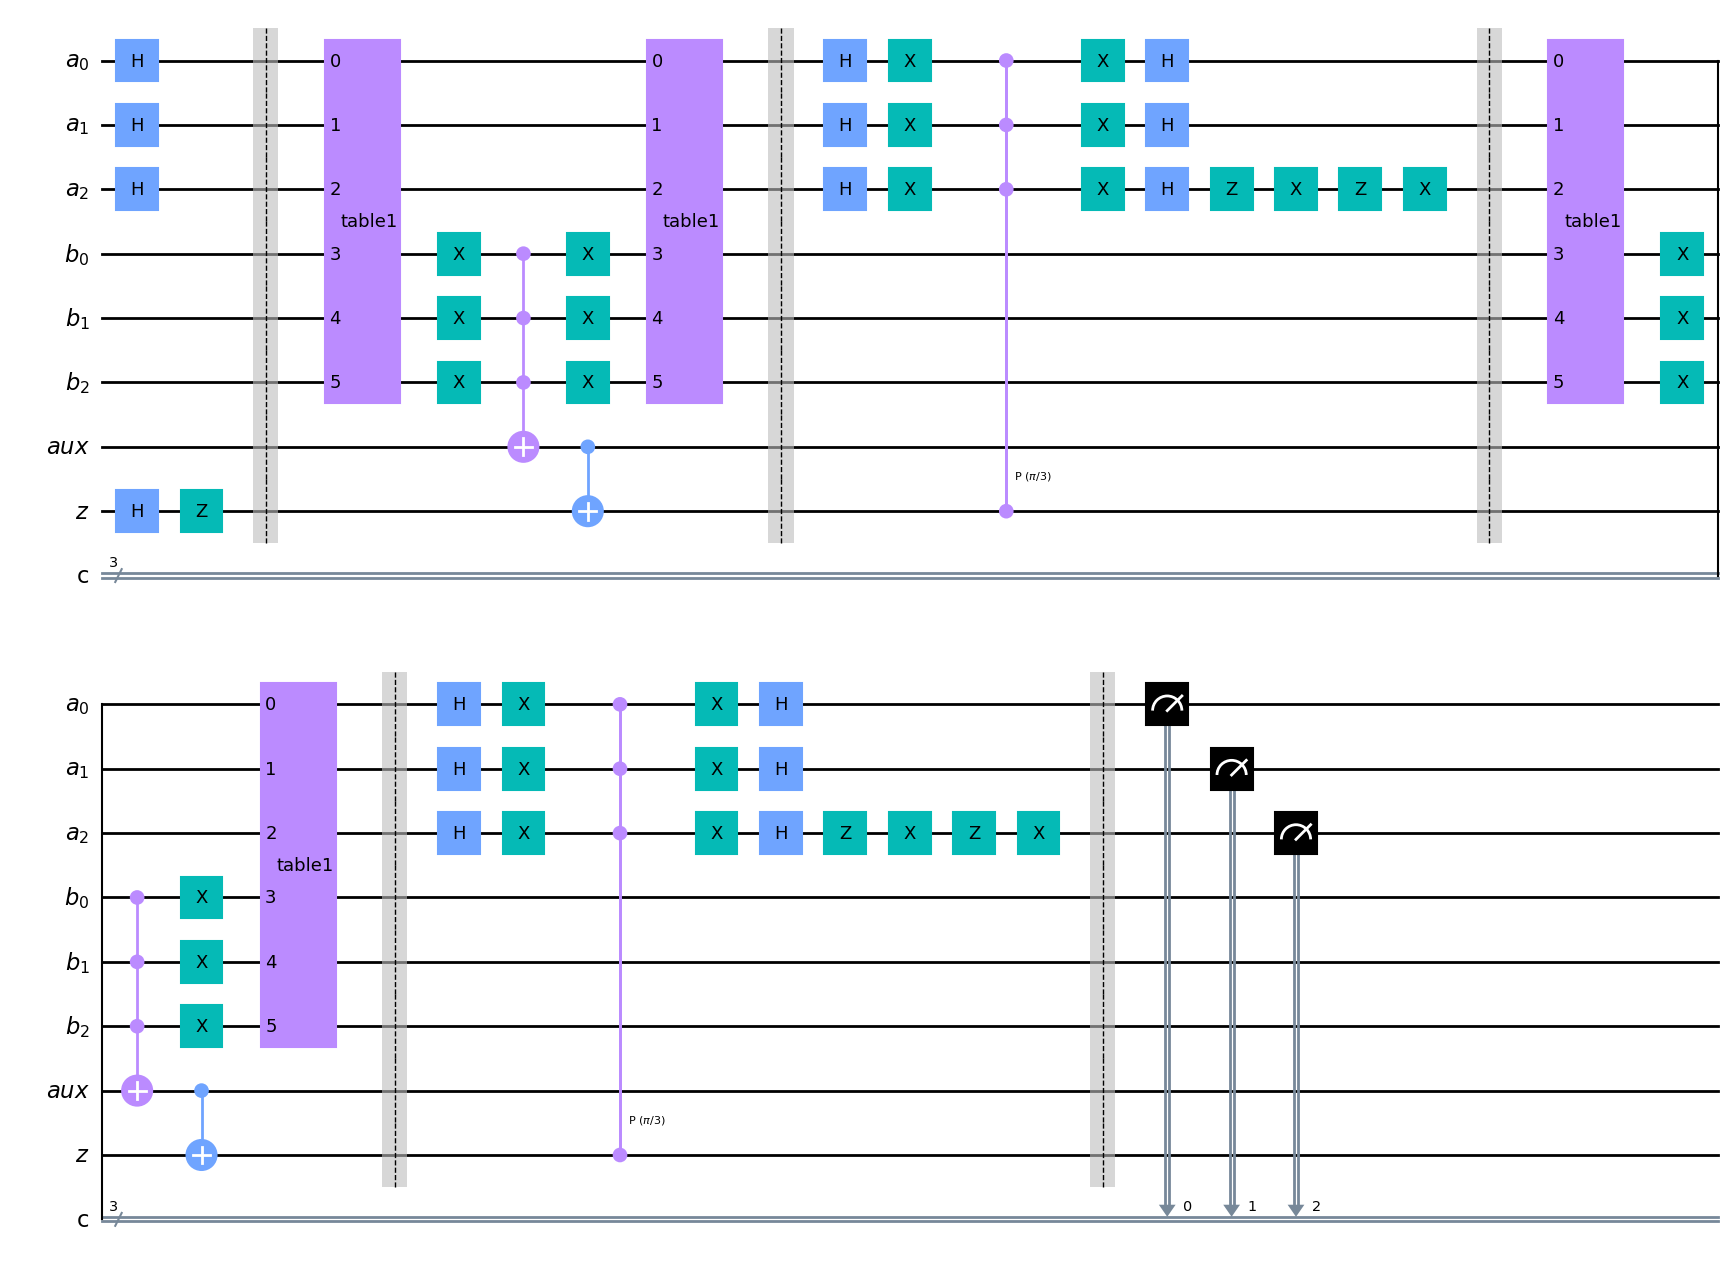

In [136]:
# Let's search for qb = 4, should get 101 (5) as output\
def delete(num, doMeasurement=False):
    qa = QuantumRegister(3, 'a')
    qb = QuantumRegister(3, 'b')
    qaRegs = qa[:]
    qbRegs = qb[:]
    aux = QuantumRegister(1, 'aux')
    z = QuantumRegister(1, 'z')
    cr = ClassicalRegister(3, 'c')
    qc = QuantumCircuit(qa, qb, aux, z, cr)



    M = int(np.floor(np.pi/4 * np.sqrt(2**len(qaRegs))))
    binary = bin(num)[2:]
    binary = '0'*(len(qa)-len(binary)) + binary
    print(binary)

    qc.h(z)
    qc.z(z)
    qc.h(qaRegs)
    qc.barrier()
    for i in range(M):
        qc.append(table1, qaRegs[:] + qbRegs[:])

        # for j in range(2**len(qaRegs)):
        #     if j != num:
        #         binary = bin(j)[2:]
        #         binary = '0'*(len(qa)-len(binary)) + binary
        #         for k in range(len(binary)):
        #             if binary[k] == '0':
        #                 qc.x(qbRegs[len(binary)-k-1])
                
        #         qc.mcx(qbRegs, aux[j])
        #         qc.cx(aux[j], aux[num])

        #         for k in range(len(binary)):
        #             if binary[k] == '0':
        #                 qc.x(qbRegs[len(binary)-k-1])
        for j in range(len(binary)):
            if binary[j] == '0':
                qc.x(qbRegs[len(binary)-j-1])

        qc.mcx(qbRegs, aux)

        for j in range(len(binary)):
            if binary[j] == '0':
                qc.x(qbRegs[len(binary)-j-1])

        # qc.mcx(aux[0:num] + aux[num+1:], aux[num])

            
        qc.append(table1, qaRegs[:] + qbRegs[:])
        qc.cx(aux, z)
        qc.barrier()

        qc.h(qaRegs)
        qc.x(qaRegs)
        qc.mcp(np.pi/3, qaRegs, z)
        qc.x(qaRegs)
        qc.h(qaRegs)
        qc.z(qaRegs[len(qaRegs)-1])
        qc.x(qaRegs[len(qaRegs)-1])
        qc.z(qaRegs[len(qaRegs)-1])
        qc.x(qaRegs[len(qaRegs)-1])
        qc.barrier()

    # qc.x(qaRegs[:])
    qc.measure(qaRegs[:], cr)

    if doMeasurement:
        backend = Aer.get_backend('qasm_simulator')
        job = execute(qc, backend, shots=1024)
        result = job.result()
        counts = result.get_counts(qc)
        return int(max(counts, key=counts.get), 2)

    return qc
    
deleteCircuit = delete(0)
deleteCircuit.draw(output='mpl')

{'100': 97, '101': 106, '001': 116, '011': 78, '111': 310, '000': 100, '010': 111, '110': 106}


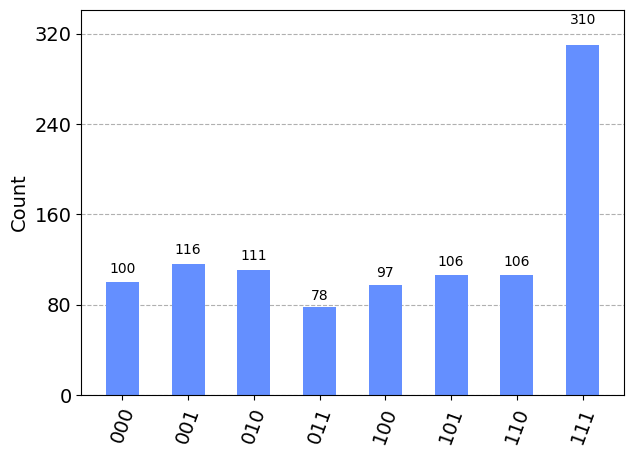

In [137]:
backend = Aer.get_backend('qasm_simulator')
job = execute(deleteCircuit, backend, shots=1024)
result = job.result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)


## Creating a new Table

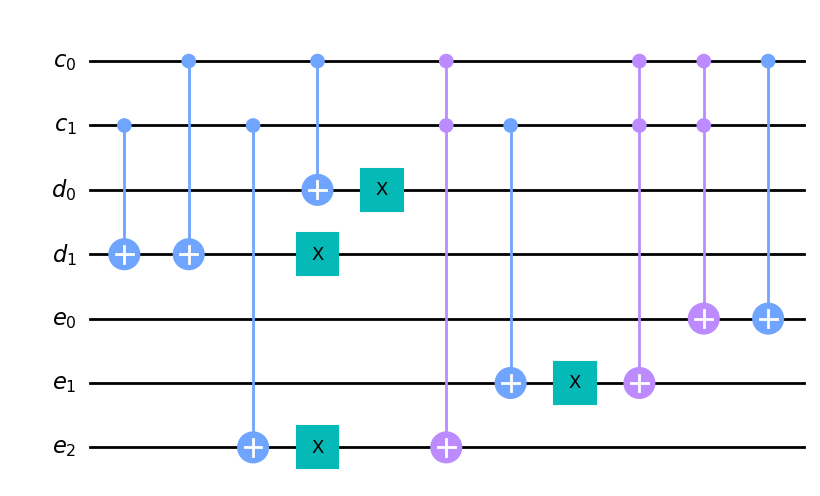

In [8]:
c = QuantumRegister(2, 'c')
d = QuantumRegister(2, 'd')
e = QuantumRegister(3, 'e')
t2 = QuantumCircuit(c, d, e)

t2.cx(c[1], d[1])
t2.cx(c[0], d[1])
t2.x(d[1])

t2.cx(c[0], d[0])
t2.x(d[0])

t2.cx(c[1], e[2])
t2.x(e[2])
t2.ccx(c[1], c[0], e[2])

t2.cx(c[1], e[1])
t2.x(e[1])
t2.ccx(c[1], c[0], e[1])

t2.ccx(c[1], c[0], e[0])
t2.cx(c[0], e[0])

table2 = t2.to_gate(label='table2')
t2.draw(output='mpl')



## Natural Join between Table 1 and Table 2 (SELECT + JOIN query)

111


/home/sum/Documents/QuantumDB/QuantumDB/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


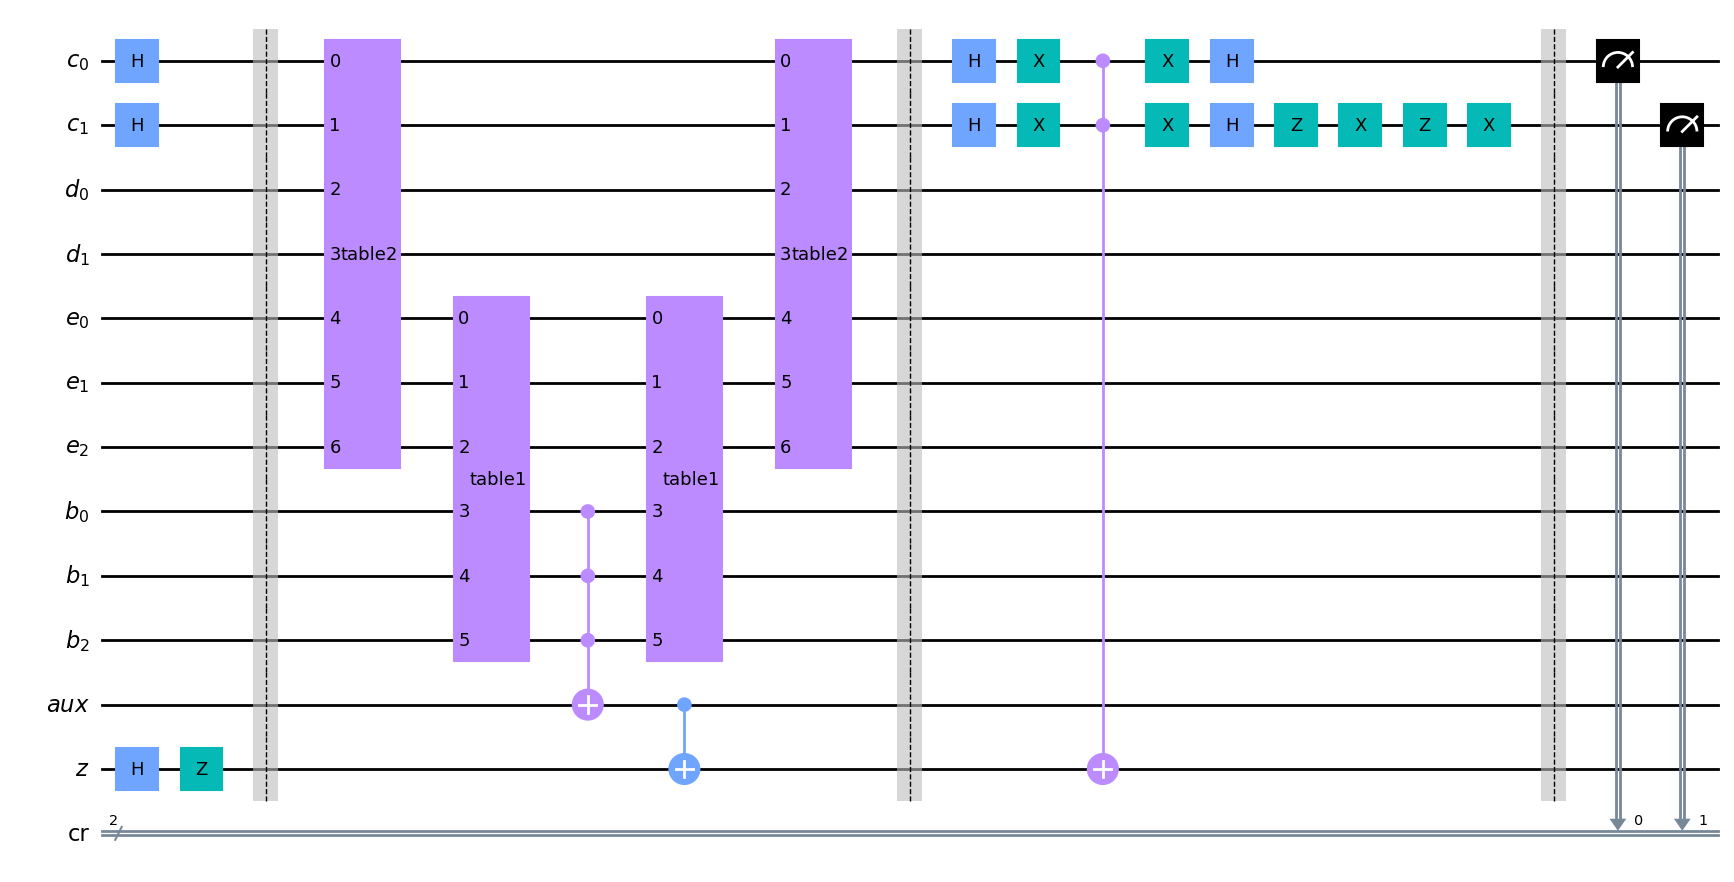

In [147]:
def join(num):
    c = QuantumRegister(2, 'c')
    d = QuantumRegister(2, 'd')
    e = QuantumRegister(3, 'e')
    b = QuantumRegister(3, 'b')
    aux = QuantumRegister(1, 'aux')
    z = QuantumRegister(1, 'z')
    cr = ClassicalRegister(2, 'cr')

    qc = QuantumCircuit(c, d, e, b, aux, z, cr)

    qc.h(z)
    qc.z(z)
    qc.h(c)
    qc.barrier()
    
    M = int(np.floor(np.pi/4 * np.sqrt(2**len(c))))
    binary = bin(num)[2:]
    binary = '0'*(len(b)-len(binary)) + binary
    print(binary)

    for i in range(M):
        qc.append(table2, c[:] + d[:] + e[:])
        qc.append(table1, e[:] + b[:])
        for j in range(len(binary)):
            if binary[j] == '0':
                qc.x(b[len(binary)-j-1])

        qc.mcx(b, aux)

        for j in range(len(binary)):
            if binary[j] == '0':
                qc.x(b[len(binary)-j-1])

            
        qc.append(table1, e[:] + b[:])
        qc.append(table2, c[:] + d[:] + e[:])
        qc.cx(aux, z)
        qc.barrier()

        qc.h(c)
        qc.x(c)
        qc.mcx(c, z)
        qc.x(c)
        qc.h(c)
        qc.z(c[len(c)-1])
        qc.x(c[len(c)-1])
        qc.z(c[len(c)-1])
        qc.x(c[len(c)-1])
        qc.barrier()

    qc.measure(c, cr)
    return qc

joinCircuit = join(7)
joinCircuit.draw(output='mpl')


    

{'11': 8, '01': 5, '00': 4, '10': 33}


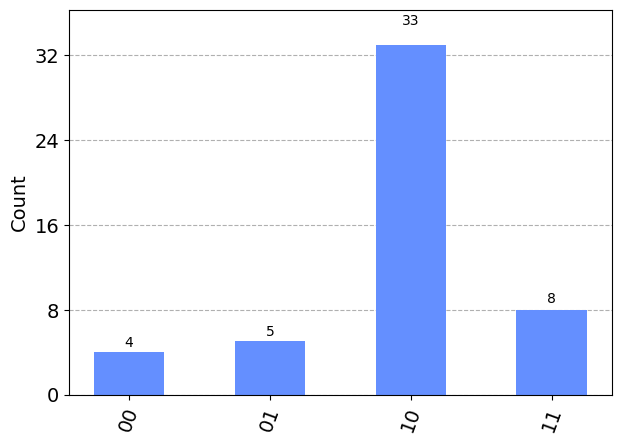

In [148]:
backend = Aer.get_backend('qasm_simulator')
job = execute(joinCircuit, backend, shots=50)
result = job.result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

## Cross Join between Table 1 and Table 2 (SELECT + CROSS JOIN query)

111


/home/sum/Documents/QuantumDB/QuantumDB/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


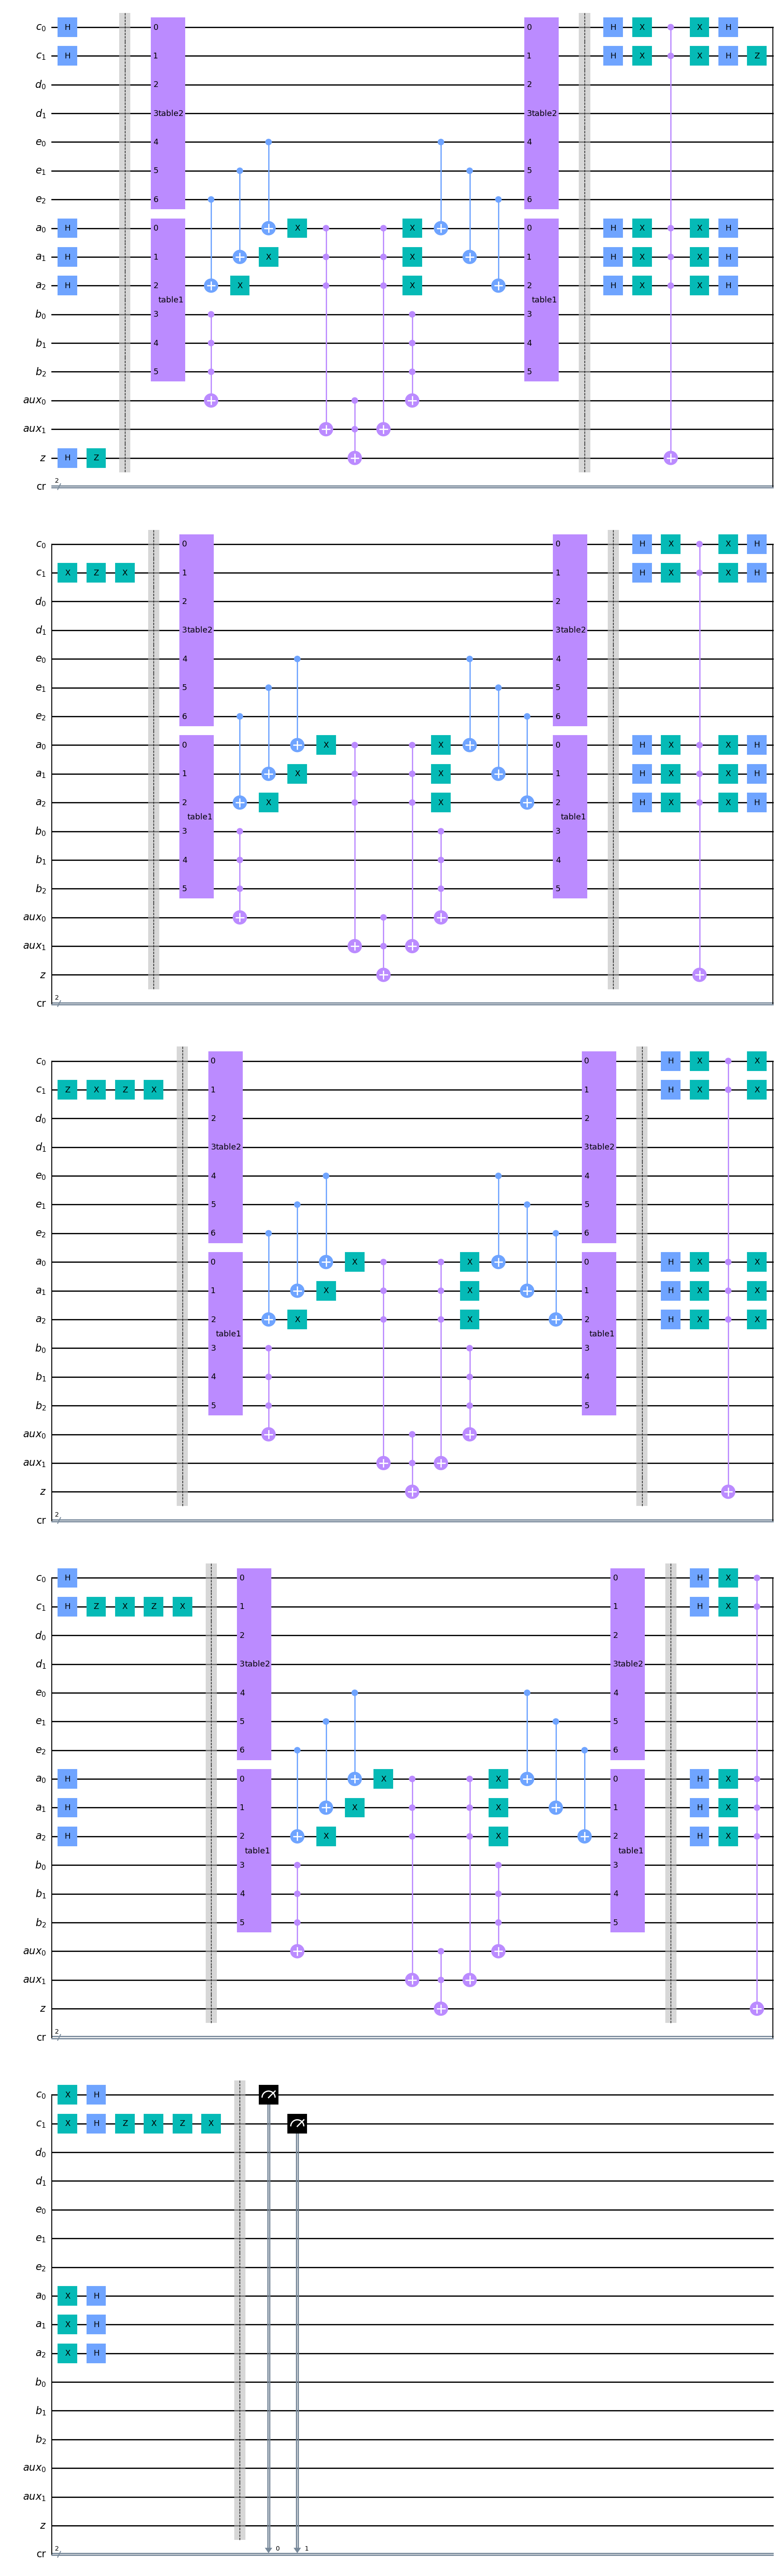

In [11]:
def crossJoin(num):
    c = QuantumRegister(2, 'c')
    d = QuantumRegister(2, 'd')
    e = QuantumRegister(3, 'e')
    a = QuantumRegister(3, 'a')
    b = QuantumRegister(3, 'b')
    aux = QuantumRegister(2, 'aux')
    z = QuantumRegister(1, 'z')
    cr = ClassicalRegister(2, 'cr')

    qc = QuantumCircuit(c, d, e, a, b, aux, z, cr)

    qc.h(z)
    qc.z(z)
    qc.h(c)
    qc.h(a)
    qc.barrier()

    M = int(np.floor(np.pi/4 * np.sqrt(2**(len(c) + len(a)))))

    binary = bin(num)[2:]
    binary = '0'*(len(b)-len(binary)) + binary
    print(binary)

    for i in range(M):
        qc.append(table2, c[:] + d[:] + e[:])
        qc.append(table1, a[:] + b[:])
        for j in range(len(binary)):
            if binary[j] == '0':
                qc.x(b[len(binary)-j-1])
        qc.mcx(b, aux[0])
        for j in range(len(binary)):
            if binary[j] == '0':
                qc.x(b[len(binary)-j-1])
        
        qc.cx(e[2], a[2])
        qc.x(a[2])
        qc.cx(e[1], a[1])
        qc.x(a[1])
        qc.cx(e[0], a[0])
        qc.x(a[0])

        qc.mcx(a, aux[1])
        qc.ccx(aux[1], aux[0], z)
        qc.mcx(a, aux[1])


        qc.x(a[0])
        qc.cx(e[0], a[0])
        qc.x(a[1])
        qc.cx(e[1], a[1])
        qc.x(a[2])
        qc.cx(e[2], a[2])
        
        for j in range(len(binary)):
            if binary[j] == '0':
                qc.x(b[len(binary)-j-1])
        qc.mcx(b, aux[0])
        for j in range(len(binary)):
            if binary[j] == '0':
                qc.x(b[len(binary)-j-1])

        qc.append(table1, a[:] + b[:])
        qc.append(table2, c[:] + d[:] + e[:])

        qc.barrier()

        qc.h(c)
        qc.x(c)
        qc.h(a)
        qc.x(a)
        qc.mcx(c[:] + a[:], z)
        qc.x(c)
        qc.h(c)
        qc.x(a)
        qc.h(a)

        qc.z(c[len(c)-1])
        qc.x(c[len(c)-1])
        qc.z(c[len(c)-1])
        qc.x(c[len(c)-1])
        qc.barrier()

    qc.measure(c, cr)
    return qc

crossJoinCircuit = crossJoin(7)
crossJoinCircuit.draw(output='mpl')


{'10': 1024}


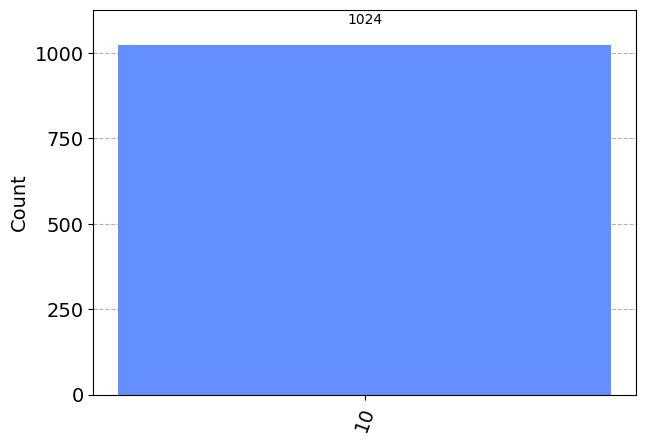

In [152]:
backend = Aer.get_backend('qasm_simulator')
job = execute(crossJoinCircuit, backend, shots=1024)
result = job.result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)